In [2]:
import os
import glob

import cv2
import numpy as np
import torch
import random

import matplotlib.pyplot as plt

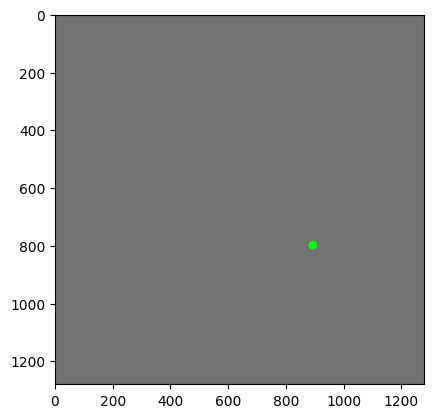

In [3]:
img_size= 640
mosaic_border = [- img_size //2, - img_size // 2]
s_mosaic = img_size * 2

mosaic = np.full((s_mosaic, s_mosaic, 3), 114, dtype=np.uint8)
yc, xc = (int(random.uniform(-x, s_mosaic + x)) for x in mosaic_border )

canvas = mosaic.copy()
cv2.circle(canvas, (xc, yc), radius=15, color=(0, 255, 0), thickness=-1)
plt.imshow(canvas)

In [4]:
from cspnext.datasets.coco import classes, colors

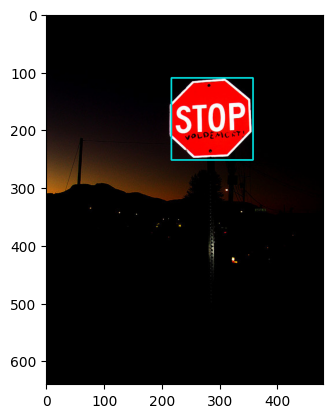

In [5]:
imp_lst = glob.glob('../assets/tiny_coco/images/*.jpg')
for _ in range(4):
    image_path = random.choice(imp_lst)
    image = cv2.imread(image_path)
    label_path = image_path.replace('images','labels').replace('.jpg', '.txt')
    labels = [list(map(eval, x.strip().split(' '))) for x in open(label_path, 'r').readlines()]
    height, width = image.shape[:2]
    for label in labels:
        cls_idx, xc, yc, w, h = label
        class_name = classes[cls_idx]
        color = colors[cls_idx]
        cv2.rectangle(
            image,
            (int( width * ( xc - w/2) ), int( height * ( yc - h/2))),
            (int( width* ( xc + w/2)), int( height * ( yc + h/2)) ),
            color=color,
            thickness=2
        )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    break

In [6]:
def mosaic_gen(image_list, labels_list, scale=[640, 640]):
    # assert len(image_list) == 4
    mosaic_range = [scale[0] // 2, scale[1] // 2]
    mosaic_image = np.full((2*scale[1], 2*scale[0], 3), 114, dtype=np.uint8)
    mosaic_labels = []
    xc, yc = [
        int(random.uniform(scale[0] - mosaic_range[0], scale[0] + mosaic_range[0])),
        int(random.uniform(scale[1] - mosaic_range[1], scale[1] + mosaic_range[1]))
    ]
    height, width = mosaic_image.shape[:2]
    # clockwise sequence
    for i, (image, labels) in enumerate(zip(image_list, labels_list)):
        h, w = image.shape[:2]
        labels = np.array(labels)
        if i == 0:
            x1a, y1a, x2a, y2a = max(0, xc - w), max(0, yc - h), xc, yc
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h
        elif i == 1:
            x1a, y1a, x2a, y2a = xc, max(0, yc - h), min(width, xc + w), yc
            x1b, y1b, x2b, y2b = 0, 0, x2a - x1a, y2a - y1a
        elif i == 2:
            x1a, y1a, x2a, y2a = xc, yc, min(width, xc + w), min(height, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, x2a - x1a, y2a - y1a
        elif i == 3:
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(height, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, y2a - y1a
        print(x1a, y1a, x2a, y2a)
        print(x1b, y1b, x2b, y2b)
        exit()
        mosaic_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
        pad_x, pad_y = x1a - x1b, y1a - y1b
        if labels.shape[0] == 0:
            continue
        labels[:, 1::2] *= w
        labels[:,2::2] *= h
        print(labels)
        image_c = image.copy()
        for label in labels:
            cls_id, xc, yc, w, h = label.tolist()
            cv2.rectangle(
                image_c,
                (int(w*(xc -w / 2)), int( h * (yc - h/2) )),
                (int(w*(xc + w/2)), int( h * (yc + h/2))),
                (0, 255, 0),
                3
            )
        cv2.imwrite(f'out_{i}.png', image_c)
        exit(0)

        labels[:, 1] += pad_x
        labels[:, 2] += pad_y

        mosaic_labels.append(labels)
    mosaic_labels = np.concatenate(mosaic_labels, axis=0)
    mosaic_labels[:, 1::2] /= mosaic_image.shape[1]
    mosaic_labels[:, 2::2] /= mosaic_image.shape[0]
    print(mosaic_labels.shape)
    # mosaic_labels[:, 1] = mosaic_labels[:, 1].clip(min=0, max=scale[1]*2)
    # mosaic_labels[:, 2] = mosaic_labels[:, 2].clip(min=0, max=scale[0]*2)
    # mosaic_labels = mosaic_labels[mosaic_labels[:, 1:].sum(axis=1) > 0]
    return mosaic_image, mosaic_labels
scale = [640, 480]
image_list = []
labels_list = []
for image_path in random.sample(imp_lst, k=4):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    image_list.append(image)
    label_path = image_path.replace('images','labels').replace('.jpg', '.txt')
    labels = [list(map(eval, x.strip().split(' '))) for x in open(label_path, 'r').readlines()]
    labels_list.append(labels)
mosaic_image, mosaic_labels = mosaic_gen(image_list, labels_list, [640, 640])
# draw
for label in mosaic_labels:
    cls_idx, xc, yc, w, h = label.tolist()
    cls_idx = int(cls_idx)
    class_name = classes[cls_idx]
    color = colors[cls_idx]
    cv2.rectangle(
        mosaic_image,
        (int( width * ( xc - w/2) ), int( height * ( yc - h/2))),
        (int( width* ( xc + w/2)), int( height * ( yc + h/2)) ),
        color=color,
        thickness=5
    )
mosaic_image = cv2.cvtColor(mosaic_image, cv2.COLOR_BGR2RGB)
plt.imshow(mosaic_image)


487 262 914 902
0 0 427 640
[[  2.    213.5   487.945 427.    216.71 ]
 [  2.    333.355 373.965  81.63   44.53 ]
 [  2.     12.64  382.705  22.7    56.75 ]
 [  2.     42.81  375.525  60.54   47.63 ]
 [  0.    294.18  351.75   15.08   27.6  ]
 [  2.    371.13  376.805 111.74  126.89 ]]
371.13 0 851.13 376.805
0 0 480.0 376.805


TypeError: slice indices must be integers or None or have an __index__ method

: 